In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import openturns as ot
import matplotlib.pyplot as plt
import seaborn as sns
import ctbenchmark as ctb
import otkerneldesign as otkd

In [3]:
from matplotlib import rc, rcParams, style
#style.use('default')
rc('font', **{'family': 'Times'})
rc('text', usetex=True)
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=14)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

# Gaussian peak problem description

In [4]:
problem = ctb.CentralTendencyGSobolProblem10N()
function = problem.getFunction()
distribution = problem.getDistribution()
problem_name = problem.getName()

In [5]:
dimension = distribution.getDimension()
candidate_set_size = int(2**13)
seq = ot.SobolSequence(distribution.getDimension())
sobol_experiment = ot.LowDiscrepancyExperiment(seq, distribution, candidate_set_size, False)
candidate_set = sobol_experiment.generate()

In [6]:
size = 50
ker_list = [ot.MaternModel([0.8], [1.0], 2.5)] * dimension
kernel = ot.ProductCovarianceModel(ker_list)
kh = otkd.KernelHerding(kernel=kernel, candidate_set=candidate_set)
kh_design = kh.select_design(size)

/home/g88077/miniconda4/envs/uqwind/lib/python3.10/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/g88077/miniconda4/envs/uqwind/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/g88077/miniconda4/envs/uqwind/lib/python3.10/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.25 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, Fut

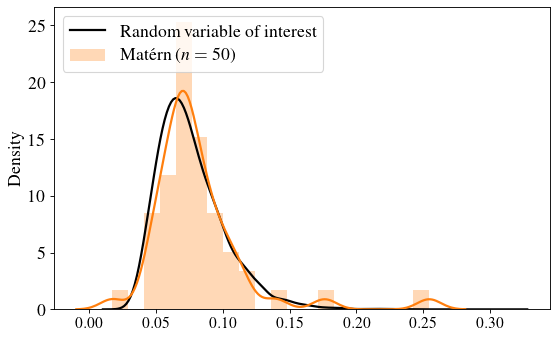

In [7]:
import seaborn as sns
output_rv = problem.getRandomVector()
output_sample = np.array(output_rv.getSample(10000)).flatten()
output_kh = function(kh_design)
kwargs = dict(hist_kws={'color':'C1', 'alpha':.3}, kde_kws={'color':'C1', 'bw':0.25, 'linewidth':2})
plt.figure(figsize=(8,5), dpi= 80)
sns.kdeplot(output_sample, color='k', linewidth=2, bw=0.2, label="Random variable of interest")
sns.distplot(output_kh, color="C0", bins=20, **kwargs, label="Matérn ($n={}$)".format(len(output_kh)))
plt.savefig('res/gsobol_histo.pdf', bbox_inches='tight');
plt.legend(loc='upper left');

# Benchmark

In [8]:
candidate_set_size = 2 ** 14
seq = ot.SobolSequence(distribution.getDimension())
sobol_experiment = ot.LowDiscrepancyExperiment(seq, distribution, candidate_set_size, False)
candidate_set = sobol_experiment.generate()

In [9]:
x_bench_sizes = list(range(6, 20, 2)) + list(range(20, 50, 5)) + list(range(50, 100, 10)) + list(range(100, 200, 50)) + list(range(200, 1000, 100))
my_methods = ['Matérn', 'Gaussian', 'Energy-distance', 'QMC']
bench = ctb.CentralTendencyBenchmark(my_methods, x_bench_sizes)

In [10]:
#bench.scale_coefficient = 0.8
#df_benchmark = bench.run_benchmark([problem], candidate_set)
#df_benchmark = df_benchmark.reset_index()
#df_benchmark.to_csv('res/ct_benchmark_{}.csv'.format(problem_name), index=False)

In [11]:
df_benchmark = pd.read_csv("res/ct_benchmark_{}.csv".format(problem_name))
df_benchmark

,Problem,Method,Size,mu,m,m*,MMD,weights sum
0,GSobol 10D (normal input),Energy-distance,6,0.076226,0.059045,0.044433,0.007305,0.928716
1,GSobol 10D (normal input),Energy-distance,8,0.076226,0.060188,0.050018,0.005244,0.943198
2,GSobol 10D (normal input),Energy-distance,10,0.076226,0.062740,0.053726,0.003962,0.953339
3,GSobol 10D (normal input),Energy-distance,12,0.076226,0.065101,0.059666,0.002532,0.963729
4,GSobol 10D (normal input),Energy-distance,14,0.076226,0.065917,0.062422,0.002120,0.969198
...,...,...,...,...,...,...,...,...
107,GSobol 10D (normal input),QMC,500,0.076226,0.075067,0.074752,0.000012,0.999240
108,GSobol 10D (normal input),QMC,600,0.076226,0.075367,0.075110,0.000009,0.999371
109,GSobol 10D (normal input),QMC,700,0.076226,0.075457,0.075447,0.000010,0.999473
110,GSobol 10D (normal input),QMC,800,0.076226,0.075558,0.075623,0.000007,0.999554


## Mean convergence

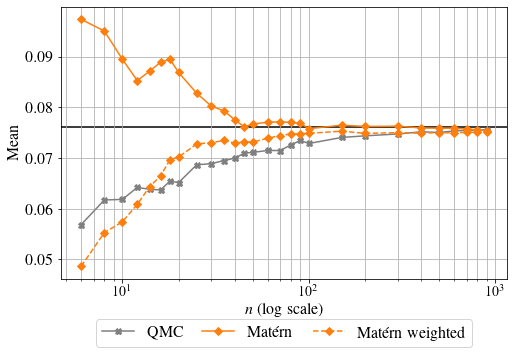

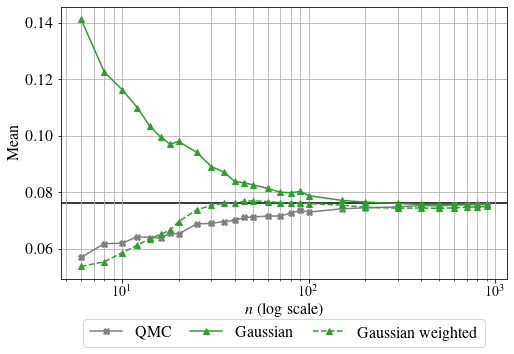

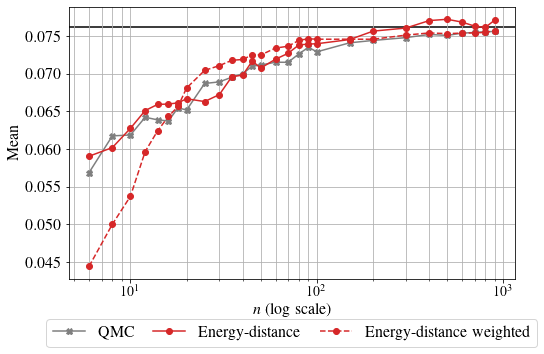

In [12]:
sfile = 'res/{}_convergence_Matern.pdf'.format(problem_name)
figure = bench.plot_ct_benchmark(df_benchmark, problem_name, methods=['QMC', 'Matérn'], save_file=sfile)
sfile = 'res/{}_convergence_Gaussian.pdf'.format(problem_name)
figure = bench.plot_ct_benchmark(df_benchmark, problem_name, methods=['QMC', None, 'Gaussian'], save_file=sfile)
sfile = 'res/{}_convergence_ED.pdf'.format(problem_name)
figure = bench.plot_ct_benchmark(df_benchmark, problem_name, methods=['QMC', None, None, 'Energy-distance'], save_file=sfile);

## MMD convergence

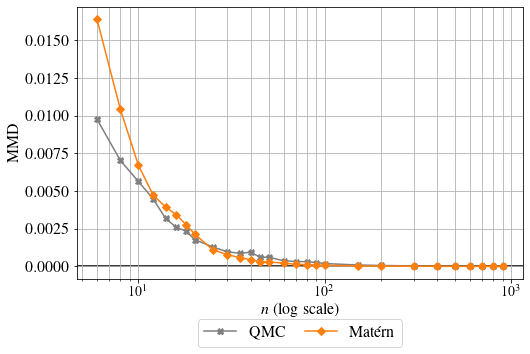

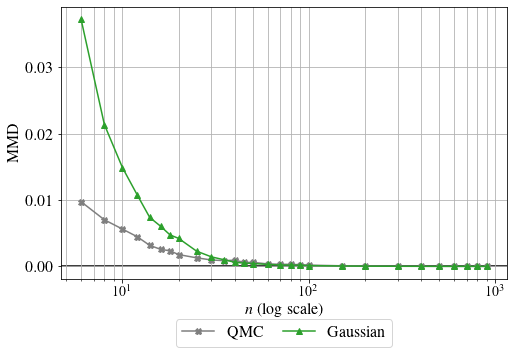

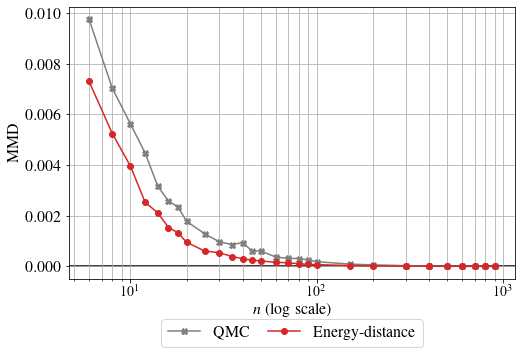

In [13]:
sfile = 'res/{}_convergence_MMD_Matern.pdf'.format(problem_name)
figure = bench.plot_ct_benchmark(df_benchmark, problem_name, methods=['QMC', 'Matérn'], is_MMD=True, save_file=sfile)
sfile = 'res/{}_convergence_MMD_Gaussian.pdf'.format(problem_name)
figure = bench.plot_ct_benchmark(df_benchmark, problem_name, methods=['QMC', None, 'Gaussian'], is_MMD=True, save_file=sfile)
sfile = 'res/{}_convergence_MMD_ED.pdf'.format(problem_name)
figure = bench.plot_ct_benchmark(df_benchmark, problem_name, methods=['QMC', None, None, 'Energy-distance'], is_MMD=True, save_file=sfile);

In [14]:
2**14

16384